# Acquisite Defective Data

## Faulty data information
- Architecture Model : Gen3.5K Steering System
- Project : CANoo LV (SFA, RWA)
- Repository : PTC Integrity CM module
- Period : 19.03 ~ 20.06
- Released software
- Data
    - Released software data (ptc checkpoint)
    - Software metric
        - loc, cyclomatic complexity, parameter count, function count
    - Halsted metric
        - loc, program length, volumume, operator, 
    - Domain metric
        - SAD 기준 up/downstream trace data (SR <-> SAD <-> SUD/SIT)
        - Experience data of changer
        - Software category (new, reuse, reused with modification)

### Load & merge data

In [458]:
# load all data from local repository

df = pd.DataFrame()
df_sfa = pd.DataFrame()
df_rwa = pd.DataFrame()

df_sfa_init = pd.read_excel("./trainData/SFA_initData.xlsx", sheet_name="dataset")
df_sfa = pd.read_excel("./trainData/SFA_Faulty_Dataset.xlsx", sheet_name="dataset")
df_rwa_init = pd.read_excel("./trainData/RWA_initData.xlsx", sheet_name="dataset")
df_rwa = pd.read_excel("./trainData/RWA_Faulty_Dataset.xlsx", sheet_name="dataset")
df_exp = pd.read_excel("./trainData/baseData.xlsx", sheet_name="name")
df_trace = pd.read_excel("./trainData/SADS_Up_Down_Trace_Report_200701.xlsx")

### EDA (탐색적 데이터 분석)
- 데이터 분석을 통한 이해
- 데이터 타입 (연속형 / 범주형 / 이산형)
- 데이터 위치와 변이, 결측치 확인 및 처리
    - describe(), info(), isnull()
    - lib : missingno (msno.matrix(), msno.bar())
    - 결측치 데이터 처리
- 데이터 산점도, 히스토그램, 상관관계 분석

#### Merge data 1 (append)
- Sfa dataframe : all released software
- Rwa dataframe : all released software


In [459]:
df_sfa = df_sfa.append([df_sfa_init,df_sfa]).reset_index(drop=True)
df_rwa = df_rwa.append([df_rwa_init,df_rwa]).reset_index(drop=True)

df = df.append([df_sfa_init,df_sfa,df_rwa_init,df_rwa]).reset_index(drop=True)

# remove duplicate instance
df_sfa = df_sfa.drop_duplicates().reset_index(drop=True)
df_rwa = df_rwa.drop_duplicates().reset_index(drop=True)
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(575, 28)

In [386]:
df_sfa.describe().to_excel('sfa_describe.xlsx', engine='xlsxwriter')
df_rwa.describe().to_excel('rwa_describe.xlsx', engine='xlsxwriter')

In [460]:
print(df_sfa['isDefective'].value_counts())
print(df_rwa['isDefective'].value_counts())

N    253
Y     56
Name: isDefective, dtype: int64
N    224
Y     46
Name: isDefective, dtype: int64


#### 클래스 비율 (Sfa, Rwa)

In [461]:
df_sfa['sysName'] = 'Sfa'
df_rwa['sysName'] = 'Rwa'

df = pd.concat([df_sfa, df_rwa], axis=0)

In [462]:
df['defectStatus'] = np.nan
df['defectStatus'] =(df_defect_arr['isDefective']=='Y').astype(int)

In [463]:
ct_df.loc[:]

isDefective,N,Y,sum,N_mean,Y_mean
sysName,,,,,
Rwa,224,46,270,82.96,17.04
Sfa,253,56,309,81.88,18.12


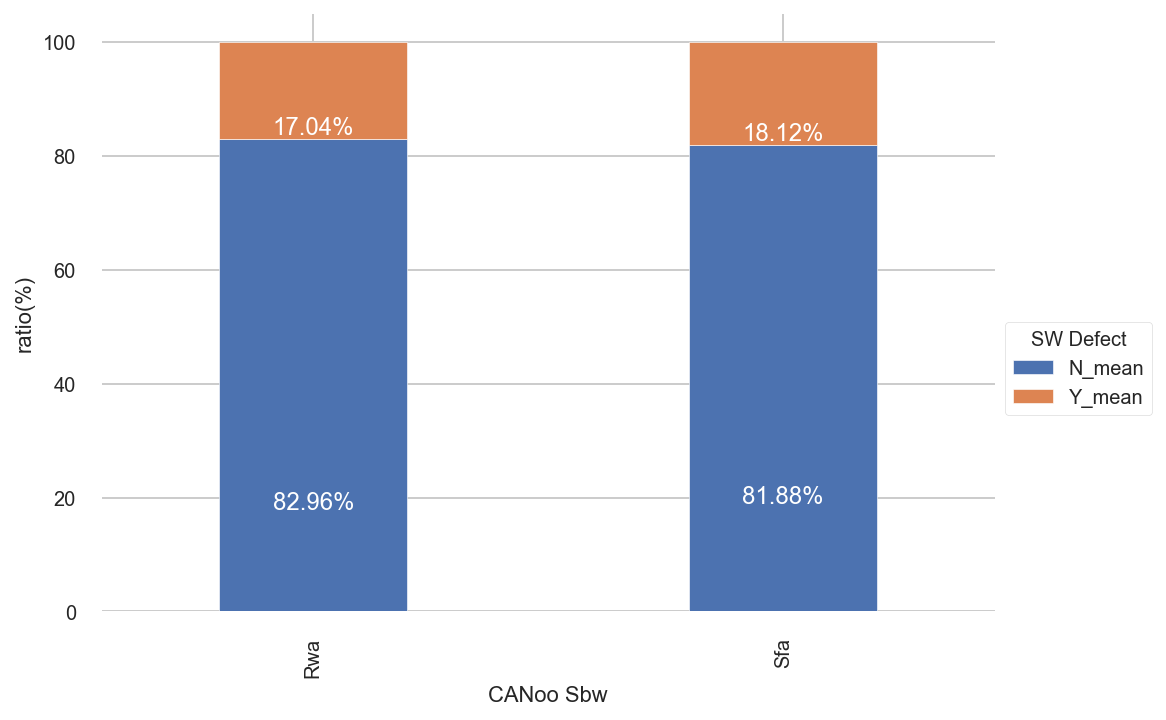

In [464]:
# f, axes = plt.subplots(1, 1, sharex=True, sharey=True)
# f.set_size_inches((16, 4)) 

#df_defect_arr.set_index('sysName').T.plot(kind='bar', stacked=True)

ct_df = df.pivot_table("defectStatus", "sysName", "isDefective", aggfunc='count')
ct_df['sum'] = ct_df['N'] + ct_df['Y']
ct_df['N_mean'] = round(ct_df['N'] / ct_df['sum'] * 100, 2)
ct_df['Y_mean'] = round(ct_df['Y'] / ct_df['sum'] * 100, 2)
ct_df_pivot = ct_df[["N_mean", "Y_mean"]]
#ct_rwa = ct_rwa / 300
ct_df_pivot.plot.bar(stacked=True, width=0.4)
plt.legend(title='SW Defect', loc='best', bbox_to_anchor=(1, 0.5))
plt.xlabel('CANoo Sbw')
plt.ylabel('ratio(%)')
plt.grid(which='major')


for i, v in enumerate(ct_df_pivot.loc[:].T):
    for j, x in enumerate(ct_df_pivot.loc[:]):
        plt.text(i, 100-ct_df_pivot.loc[v, x], "{}%".format(ct_df_pivot.loc[v, x]), fontsize=12, horizontalalignment='center', 
                 verticalalignment='bottom', color='#ffffff')

plt.show()

In [465]:
df = df.copy()

#### 데이터 전처리 & Merge data 2 (merge)
- 데이터 전처리
    - SWC version 으로부터 revision frequency 추출
    - SWC name 에서 only SWC name 만 추출
- 데이터 통합
    - faulty data <- experience data (on engineer name)
    - faulty data <- trace data (on software component)

In [468]:
df.isnull().sum()

Order              0
swcName            1
swcVer             1
progLength         1
vocaCnt            1
volume             1
difficultyLv       1
progLv             1
effortToImpl       1
timeToImpl         1
nloc               1
minParaCnt         1
maxParaCnt         1
totalParaCnt       1
funCnt             1
minCyclo           1
maxCyclo           1
avgCyclo           1
expMonths         21
impactBoundary    21
creationInfo       1
nrev               1
memberRev          1
pPORT             79
rPORT             79
activityId         1
crId               1
isDefective        1
sysName            0
defectStatus       0
dtype: int64

In [466]:
df.columns

Index(['Order', 'swcName', 'swcVer', 'progLength', 'vocaCnt', 'volume',
       'difficultyLv', 'progLv', 'effortToImpl', 'timeToImpl', 'nloc',
       'minParaCnt', 'maxParaCnt', 'totalParaCnt', 'funCnt', 'minCyclo',
       'maxCyclo', 'avgCyclo', 'expMonths', 'impactBoundary', 'creationInfo',
       'nrev', 'memberRev', 'pPORT', 'rPORT', 'activityId', 'crId',
       'isDefective', 'sysName', 'defectStatus'],
      dtype='object')

In [467]:
# faulty data에서 swcName 중 only software component split 하여 moduleName 컬럼 추가
# faulty data에서 creationInfo 중 changer split 하여 changer 컬럼 추가

df["moduleName"] = pd.DataFrame([name[-1] for name in df['swcName'].str.split('/')])
df['creationInfo'] = df.fillna('함설희 (seolhee.ham) on Mar 8, 2019 9:59:56 AM KST')['creationInfo']
df["changer"] = pd.DataFrame([name[0].strip() for name in df['creationInfo'].str.split('(')])
df_exp.rename(columns={'name':'changer'}, inplace=True)
df_trace.rename(columns={'swcName':'moduleName'}, inplace=True)

TypeError: 'float' object is not subscriptable

In [40]:
# fauly data <- experience data
# fauly data <- trace data

df_1 = pd.merge(df, df_exp, on='changer', how='left')
train = pd.merge(df_1, df_trace, on='moduleName', how='left')

In [48]:
train

,Order,swcName,swcVer,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,...,moduleName,changer,expMonths,start date to join,ID,Upstream Trace Count,Downstream Trace Count,Implements,Decomposes To,Verified By
0,1.20-num-1,Cdds/MotCtrl/DmaMc,1.2,2559,359,21720.382647,38.584071,14.589869,838060.781761,46558.932320,...,DmaMc,함설희,6.000000,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,1.20-num-2,Cdds/MotCtrl/DQTransform,1.7,205,46,1132.330201,16.411765,4.203998,18583.536828,1032.418713,...,DQTransform,조소영,65.737705,2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2,1.20-num-3,Cdds/MotCtrl/MotAg,1.2,936,150,6766.174294,35.389313,5.402552,239450.259759,13302.792209,...,MotAg,함설희,6.000000,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,1.20-num-4,Cdds/MotCtrl/MotCtrlSdl,1.34,315,99,2088.247335,14.265060,10.262064,29788.974036,1654.943002,...,MotCtrlSdl,원우석,149.540984,2008-01-07,NaN,NaN,NaN,NaN,NaN,NaN
4,1.20-num-5,Cdds/MotCtrl/MotICtrl,1.7,1565,226,12238.580076,26.476077,17.459177,324029.583022,18001.643501,...,MotICtrl,신창우,77.704918,2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,1.149-num-210,Swcs/FailrMgr,1.22,1408,258,11279.807976,30.462185,12.155690,343607.595896,19089.310883,...,FailrMgr,조소영,65.737705,2015-01-06,3127575.0,9.0,58.0,9.0,2.0,56.0
554,1.149-num-211,Swcs/IntPwrSply_ARG82801_1,1.10,1241,206,9538.947154,33.486486,8.506703,319425.824976,17745.879165,...,IntPwrSply_ARG82801_1,민승기,118.557377,2010-08-09,3127824.0,15.0,10.0,15.0,2.0,8.0
555,1.149-num-212,Swcs/ModMgr,1.5,1903,191,14419.847060,31.221910,14.792505,450215.168734,25011.953819,...,ModMgr,민승기,118.557377,2010-08-09,3127745.0,37.0,1.0,37.0,1.0,0.0
556,1.149-num-213,Swcs/RackAgSnsr,1.22,1223,123,8490.695240,45.631068,4.077763,387439.491535,21524.416196,...,RackAgSnsr,정다은,23.770492,2018-07-09,3127600.0,10.0,1.0,10.0,1.0,0.0


In [58]:
train_profile.columns

Index(['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv',
       'effortToImpl', 'timeToImpl', 'nloc', 'minParaCnt', 'maxParaCnt',
       'totalParaCnt', 'funCnt', 'minCyclo', 'maxCyclo', 'avgCyclo', 'revFreq',
       'pPORT', 'rPORT', 'isDefective', 'moduleName', 'expMonths',
       'Upstream Trace Count', 'Downstream Trace Count', 'Implements',
       'Decomposes To', 'Verified By'],
      dtype='object')

In [57]:
train_profile = train.drop(columns=['Order','swcVer','swcName','start date to join ','ID','impactBoundary','creationInfo','expLvOfDev',
                                   'changer'])

In [50]:
train_profile.describe().to_excel("df_describe.xlsx", engine="xlsxwriter")

#### Pandas data profiling

In [46]:
from pandas_profiling import ProfileReport

In [51]:
profile = ProfileReport(train_profile, title="Pandas Profiling Report")

In [47]:
profile.to_file('faulty_data_profile.html')

In [12]:
# train_1
# column drop, ordering
# changed to train_1

train_1 = train[['moduleName', 'progLength', 'vocaCnt', 'volume',
       'difficultyLv', 'progLv', 'effortToImpl', 'timeToImpl', 'nloc',
       'minParaCnt', 'maxParaCnt', 'totalParaCnt', 'funCnt', 'minCyclo',
       'maxCyclo', 'avgCyclo', 'pPORT', 'rPORT', 'revFreq', 'changer', 'expMonths', 
       'Implements', 'Decomposes To', 'Verified By', 'isDefective']]

In [13]:
# column name change

train_1.rename(columns={'Downstream Trace Count':'downTrace', 
                      'Implements':'nreq',
                      'Decomposes To':'nsud',
                       'Verified By':'ntest'}, inplace=True)

In [14]:
# -1 : 미 결함, 1 : 결함

train_1['isDefective'] = train_1['isDefective'].replace({'N':-1, 'Y':1})
train_1['isDefective'].value_counts()*100/len(train_1)

-1.0    82.258065
 1.0    17.562724
Name: isDefective, dtype: float64

#### 데이터 결측치 처리

In [15]:
train_1.shape

(558, 25)

In [16]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558 entries, 0 to 557
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   moduleName    558 non-null    object 
 1   progLength    558 non-null    int64  
 2   vocaCnt       558 non-null    int64  
 3   volume        558 non-null    float64
 4   difficultyLv  558 non-null    float64
 5   progLv        558 non-null    float64
 6   effortToImpl  558 non-null    float64
 7   timeToImpl    558 non-null    float64
 8   nloc          558 non-null    int64  
 9   minParaCnt    558 non-null    int64  
 10  maxParaCnt    558 non-null    int64  
 11  totalParaCnt  558 non-null    int64  
 12  funCnt        558 non-null    int64  
 13  minCyclo      558 non-null    int64  
 14  maxCyclo      558 non-null    int64  
 15  avgCyclo      558 non-null    float64
 16  pPORT         482 non-null    float64
 17  rPORT         482 non-null    float64
 18  revFreq       558 non-null    

- pPort, rPort
- changer
- nreq, nsud, ntest

In [17]:
train_1.loc[train_1['expMonths'].isnull()]

,moduleName,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,...,avgCyclo,pPORT,rPORT,revFreq,changer,expMonths,nreq,nsud,ntest,isDefective
14,SysTmr,199,40,1059.063691,21.214286,2.353235,22467.279728,1248.182207,47,1,...,1.200000,NaN,NaN,2,sohee.park,NaN,NaN,NaN,NaN,-1.0
18,BattUDiagc,313,50,1766.526987,18.789474,5.003697,33192.112342,1844.006241,313,1,...,9.000000,123.0,13.0,35,허진욱,NaN,14.0,2.0,0.0,-1.0
20,DiagPreCond,1131,210,8724.811680,25.465969,13.453512,222185.780177,12343.654454,274,1,...,11.500000,124.0,17.0,12,김영범,NaN,1.0,2.0,0.0,-1.0
22,FailrMgr,745,139,5303.611099,29.752066,5.991525,157793.388075,8766.299337,119,1,...,3.500000,134.0,12.0,17,이재혁,NaN,9.0,2.0,56.0,-1.0
23,GateDrvr,1533,185,11545.607779,35.264881,9.283932,407154.483848,22619.693547,326,1,...,5.666667,120.0,16.0,6,이재혁,NaN,10.0,2.0,0.0,-1.0
31,MotAgDiagc,358,41,1918.003618,32.732143,1.790196,62780.368414,3487.798245,60,1,...,3.500000,0.0,4.0,8,허진욱,NaN,15.0,2.0,0.0,-1.0
34,MotPhaOpenDiagc,1017,103,6800.171036,36.505747,5.102668,248245.324262,13791.406903,191,1,...,13.500000,1.0,11.0,6,허진욱,NaN,2.0,2.0,0.0,-1.0
40,PartnWdgIf,29,15,113.299827,4.000000,7.081239,453.199309,25.177739,9,1,...,1.000000,121.0,7.0,7,sohee.park,NaN,1.0,0.0,0.0,-1.0
46,SigCorrlnDiagc,213,57,1242.405573,14.325581,6.053951,17798.182162,988.787898,48,1,...,5.000000,120.0,15.0,11,sohee.park,NaN,1.0,2.0,0.0,-1.0
47,SysLib,72,22,321.079077,15.000000,1.427018,4816.186148,267.565897,2030,1,...,4.000000,NaN,NaN,13,sohee.park,NaN,NaN,NaN,NaN,-1.0


In [18]:
# changer 의 experience month 결측치
# sbw 초기 carry over 된 컴포넌트로서 실제 sbw 담당자는 아니고, 과거 타 프로젝트에서 SWC 를 마지막으로 변경했던 사람
# 데이터 수 자체가 너무 적어 지우는 것보다는 mean 값으로 채우기 ?

# 데이터 삭제

train_2 = train_1.dropna(subset=['expMonths', 'isDefective']).reset_index(drop=True)

In [19]:
# 경력과 loc 간의 비율을 위한 컬럼 추가

train_2["rating"] = train_2["nloc"] / train_2["expMonths"]

In [20]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   moduleName    519 non-null    object 
 1   progLength    519 non-null    int64  
 2   vocaCnt       519 non-null    int64  
 3   volume        519 non-null    float64
 4   difficultyLv  519 non-null    float64
 5   progLv        519 non-null    float64
 6   effortToImpl  519 non-null    float64
 7   timeToImpl    519 non-null    float64
 8   nloc          519 non-null    int64  
 9   minParaCnt    519 non-null    int64  
 10  maxParaCnt    519 non-null    int64  
 11  totalParaCnt  519 non-null    int64  
 12  funCnt        519 non-null    int64  
 13  minCyclo      519 non-null    int64  
 14  maxCyclo      519 non-null    int64  
 15  avgCyclo      519 non-null    float64
 16  pPORT         451 non-null    float64
 17  rPORT         451 non-null    float64
 18  revFreq       519 non-null    

In [21]:
train_2.describe()

,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,maxParaCnt,...,avgCyclo,pPORT,rPORT,revFreq,expMonths,nreq,nsud,ntest,isDefective,rating
count,519.000000,519.000000,519.000000,519.000000,519.000000,5.190000e+02,519.000000,519.000000,519.000000,519.000000,...,519.000000,451.000000,451.000000,519.000000,519.000000,435.000000,435.000000,435.000000,519.000000,519.000000
mean,1175.327553,143.508671,9469.466040,27.216974,13.179371,4.334854e+05,24082.520957,370.996146,0.932563,2.040462,...,5.280244,44.720621,19.044346,10.988439,58.565526,17.144828,1.588506,6.997701,-0.622351,19.424942
std,1746.061474,213.197978,16740.492952,18.432723,29.943358,8.670128e+05,48167.378101,566.606225,0.251020,1.782666,...,4.607872,53.273191,28.056654,11.826932,42.737164,28.552558,0.511036,17.504904,0.783494,57.019627
min,6.000000,5.000000,13.931569,0.500000,1.651688,6.965784e+00,0.386988,12.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,-1.000000,0.100307
25%,205.000000,52.000000,1248.238463,14.325581,4.827079,1.822527e+04,1012.514841,87.500000,1.000000,1.000000,...,2.095238,3.000000,6.000000,4.000000,23.770492,2.000000,1.000000,0.000000,-1.000000,1.494908
50%,592.000000,97.000000,3864.217599,26.476077,5.943272,9.904215e+04,5502.341409,152.000000,1.000000,1.000000,...,4.250000,9.000000,10.000000,8.000000,53.606557,8.000000,2.000000,0.000000,-1.000000,4.125557
75%,1185.000000,153.000000,8471.870909,35.327097,9.861810,3.217277e+05,17873.761333,392.000000,1.000000,2.000000,...,7.062500,122.000000,19.000000,12.000000,77.704918,15.000000,2.000000,0.000000,-1.000000,14.691651
max,11039.000000,1951.000000,120656.248613,78.030882,271.946401,3.844545e+06,213585.824269,4624.000000,1.000000,8.000000,...,35.333333,144.000000,172.000000,85.000000,149.540984,114.000000,2.000000,72.000000,1.000000,770.666667


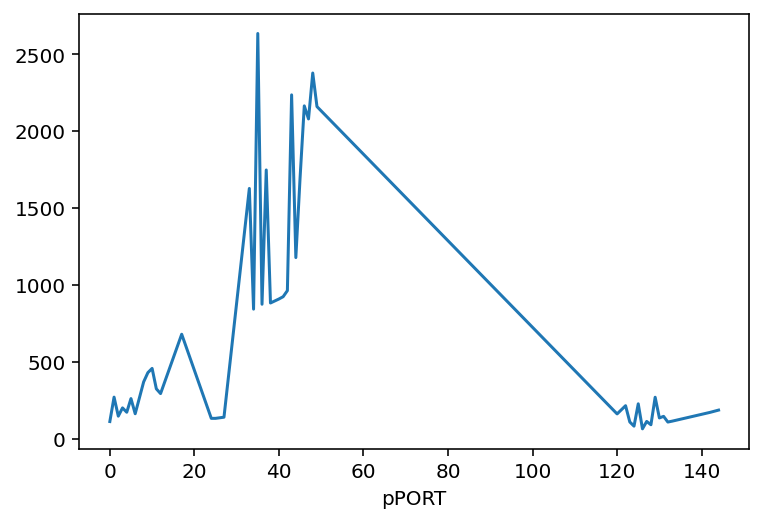

In [22]:
train_2.groupby('pPORT')['nloc'].mean().plot()

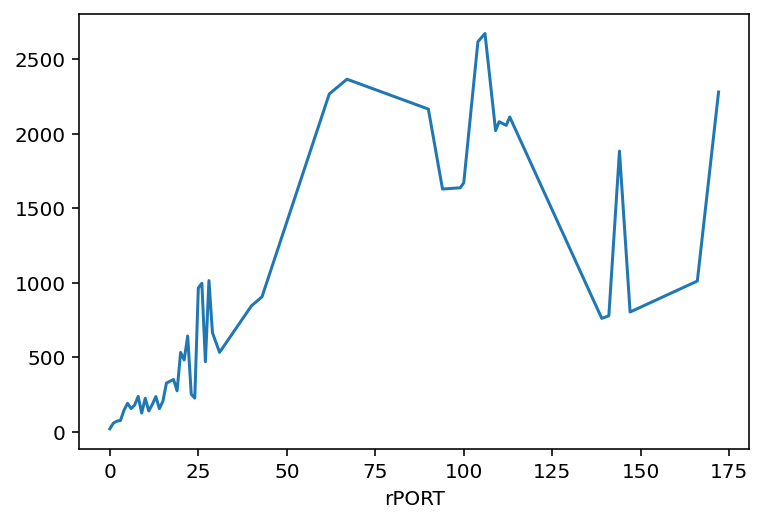

In [23]:
train_2.groupby('rPORT')['nloc'].mean().plot()    

In [24]:
train_2[(train_2['rPORT']>100) & (train_2['nloc']<2000)]

,moduleName,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,...,pPORT,rPORT,revFreq,changer,expMonths,nreq,nsud,ntest,isDefective,rating
14,ApplCom,7,7,19.651484,2.000000,4.912871,3.930297e+01,2.183498,1920,1,...,37.0,144.0,8,조영훈,50.852459,114.0,1.0,0.0,-1.0,37.756286
114,SteerTarTqGenr,4655,332,38985.808553,59.522508,11.003836,2.320533e+06,128918.505721,760,1,...,1.0,139.0,5,홍승규,103.016393,6.0,1.0,0.0,-1.0,7.377467
169,SteerTarTqGenr,4748,335,39826.306071,60.023885,11.054060,2.390530e+06,132807.201640,778,1,...,1.0,141.0,6,홍승규,103.016393,6.0,1.0,0.0,-1.0,7.552196
193,SteerTarTqGenr,4748,335,39826.306071,60.023885,11.054060,2.390530e+06,132807.201640,778,1,...,1.0,141.0,7,홍승규,103.016393,6.0,1.0,0.0,-1.0,7.552196
237,SteerTarTqGenr,4925,346,41540.544021,57.239264,12.678974,2.377750e+06,132097.230987,803,1,...,1.0,147.0,8,이재우,17.803279,6.0,1.0,0.0,-1.0,45.104052
264,SteerTarTqGenr,6255,405,54179.422002,61.766234,14.201432,3.346459e+06,185914.380259,1011,1,...,1.0,166.0,12,이재우,17.803279,6.0,1.0,0.0,-1.0,56.787293
318,ApplCom,7,7,19.651484,2.000000,4.912871,3.930297e+01,2.183498,1847,1,...,37.0,144.0,13,조영훈,50.852459,114.0,1.0,0.0,-1.0,36.320761


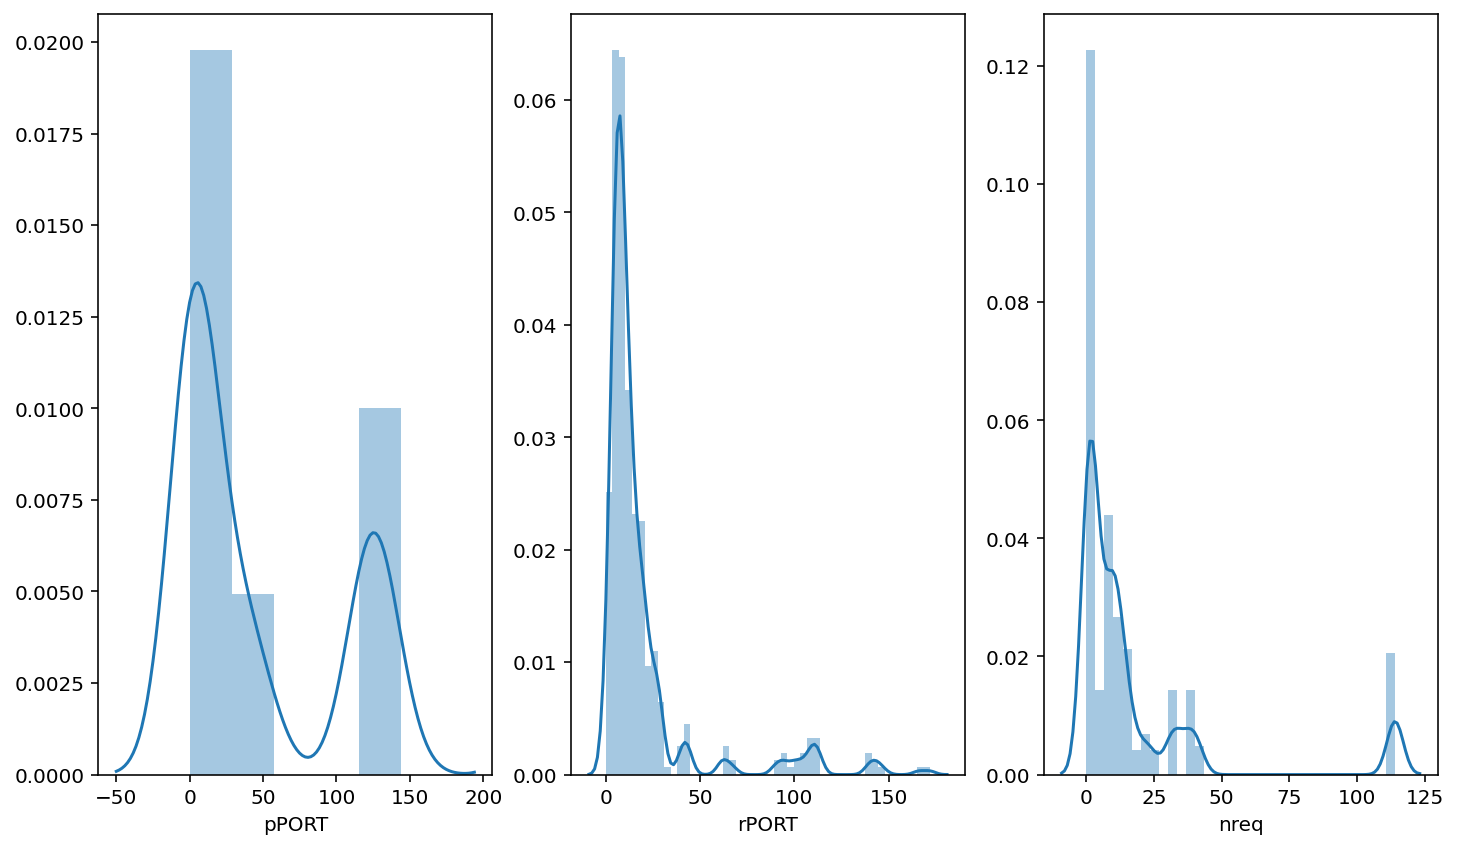

In [25]:
# 결측치 데이터를 어떻게 채울지 분석 필요 (pPOrt, rPort)
# pPORT 결측치 데이터의 경향성이 없어 해당 instance 삭제 ?

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(12, 7)

sns.distplot(train_2.pPORT, ax=ax1)
sns.distplot(train_2.rPORT, ax=ax2)
sns.distplot(train_2.nreq, ax=ax3)

In [26]:
# NaN 이 포함된 p-port, r-port에 대해 row 삭제 처리 (SW architecture 가 없어 r/p port 확인이 어려운 software component)
# train_1 는 컬럼 정리한 data frame
# train_2 는 NaN 데이터 삭제된 data frame

train_3 = train_2.dropna(axis=0, how='any').reset_index(drop=True)

In [95]:
train_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   moduleName    410 non-null    object 
 1   progLength    410 non-null    int64  
 2   vocaCnt       410 non-null    int64  
 3   volume        410 non-null    float64
 4   difficultyLv  410 non-null    float64
 5   progLv        410 non-null    float64
 6   effortToImpl  410 non-null    float64
 7   timeToImpl    410 non-null    float64
 8   nloc          410 non-null    int64  
 9   minParaCnt    410 non-null    int64  
 10  maxParaCnt    410 non-null    int64  
 11  totalParaCnt  410 non-null    int64  
 12  funCnt        410 non-null    int64  
 13  minCyclo      410 non-null    int64  
 14  maxCyclo      410 non-null    int64  
 15  avgCyclo      410 non-null    float64
 16  pPORT         410 non-null    float64
 17  rPORT         410 non-null    float64
 18  revFreq       410 non-null    

In [27]:
# SWC 별 결함 발생 수

train_3[train_3['isDefective'] == 1]['moduleName'].value_counts()

ApplCom             15
FailrMgr            13
PpkTrim              9
RackAgSnsr           5
ModMgr               5
ActrMot              5
PinionAg             5
RackPosn             5
IoHwAb_Discrete      4
MotAgEtc             3
MotAgDiagc           3
DiagPreCond          2
SteerWhlTq           2
PpkPolarity          2
SigCorrlnDiagc       2
IoHwAb_D             2
SbwSigVotg           2
TarTqArbn            1
SteerAgTrckgCtrl     1
TarAgSrcSel          1
SFACtrlSigProc       1
TarTorsBarTqGenr     1
TarPosnArbn          1
CtrlModMgr           1
Name: moduleName, dtype: int64

In [29]:
train_3.groupby(['moduleName'])['isDefective'].value_counts()

moduleName      isDefective
ActrMot          1.0            5
                -1.0            4
AnalyticRec     -1.0            4
ApplCom         -1.0           15
                 1.0           15
                               ..
TqRampCtrl      -1.0            8
TqTrckgCtrl     -1.0            3
TunVrntSel      -1.0            6
VehKinematCtrl  -1.0            5
VehSpd          -1.0            4
Name: isDefective, Length: 81, dtype: int64

In [30]:
# 결함 발생 있는 SWC 에 대해 미 결함 행 제거

cols_1 = ['ApplCom', 'FailrMgr', 'PpkTrim', 'PinionAg', 'RackPosn', 'ActrMot', 'RackAgSnsr', 'ModMgr', 'IoHwAb_Discrete']
cols_2 = ['MotAgDiagc', 'MotAgEtc', 'SteerWhlTq',  'PpkPolarity', 'SigCorrlnDiagc','SbwSigVotg', 'DiagPreCond', 'IoHwAb_D']

for name in cols_1:
    train_3.drop(train_3[(train_3['moduleName'] == name) & (train_3['isDefective'] == -1)].index, inplace=True)

In [31]:
train_3['isDefective'].value_counts()*100/len(train_3)

#df_4["isDefective"].value_counts(normalize=True)*100

-1.0    73.546512
 1.0    26.453488
Name: isDefective, dtype: float64

#### 데이터 시각화를 통한 분석 (seaborn)

In [32]:
sns.set(style='darkgrid')

In [33]:
train_3.columns

Index(['moduleName', 'progLength', 'vocaCnt', 'volume', 'difficultyLv',
       'progLv', 'effortToImpl', 'timeToImpl', 'nloc', 'minParaCnt',
       'maxParaCnt', 'totalParaCnt', 'funCnt', 'minCyclo', 'maxCyclo',
       'avgCyclo', 'pPORT', 'rPORT', 'revFreq', 'changer', 'expMonths', 'nreq',
       'nsud', 'ntest', 'isDefective', 'rating'],
      dtype='object')

In [34]:
#train_3[(train_3['expMonths']<80) & (train_3['nloc']>1200)]
train_3[train_3['moduleName'] =='ApplCom']

,moduleName,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,...,pPORT,rPORT,revFreq,changer,expMonths,nreq,nsud,ntest,isDefective,rating
117,ApplCom,703,69,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2056,1,...,49.0,112.0,46,박민기,23.770492,114.0,1.0,0.0,1.0,86.493793
130,ApplCom,703,69,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2056,1,...,49.0,112.0,47,박민기,23.770492,114.0,1.0,0.0,1.0,86.493793
142,ApplCom,703,69,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2056,1,...,49.0,112.0,48,박민기,23.770492,114.0,1.0,0.0,1.0,86.493793
159,ApplCom,703,69,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2108,1,...,49.0,113.0,53,박민기,23.770492,114.0,1.0,0.0,1.0,88.681379
164,ApplCom,703,69,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2117,1,...,49.0,113.0,55,박민기,23.770492,114.0,1.0,0.0,1.0,89.060000
171,ApplCom,3905,352,33034.080471,28.927928,39.475494,9.556075e+05,53089.305501,2361,1,...,49.0,67.0,68,Yadunandan Kasu,12.426230,114.0,1.0,0.0,1.0,190.001319
192,ApplCom,4261,369,36335.579523,29.178571,42.677998,1.060220e+06,58901.127917,2371,1,...,49.0,67.0,72,Yadunandan Kasu,12.426230,114.0,1.0,0.0,1.0,190.806069
201,ApplCom,4259,372,36368.277377,28.796034,43.858864,1.047262e+06,58181.230647,2379,1,...,48.0,62.0,77,Yadunandan Kasu,12.426230,114.0,1.0,0.0,1.0,191.449868
341,ApplCom,823,74,5110.380120,36.762295,3.781360,1.878693e+05,10437.183442,2024,1,...,45.0,109.0,55,박민기,23.770492,114.0,1.0,0.0,1.0,85.147586
353,ApplCom,823,74,5110.380120,36.762295,3.781360,1.878693e+05,10437.183442,2019,1,...,45.0,109.0,56,박민기,23.770492,114.0,1.0,0.0,1.0,84.937241


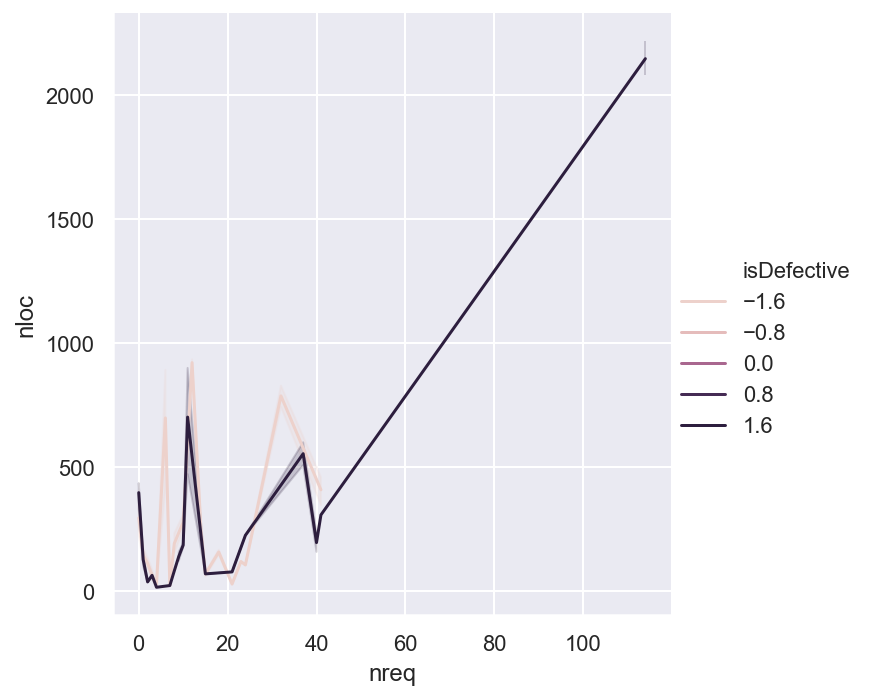

In [35]:
# 경력과 라인수 관계에 결함 발생이 어떻게 되는 지?
# 500 loc 이하에서는 경력과 관계없이 결함 발생이 거의 없음
# 경력이 짧고, LOC 가 길수록 결함 발생 높음 (60개월 미만까지)
# 경력이 60개월 초과 이후에서는, LOC 가 길수록 결함 발생 높음 (60개월 미만까지)

sns.relplot(x='nreq', y='nloc', kind='line', data=train_3, hue='isDefective')

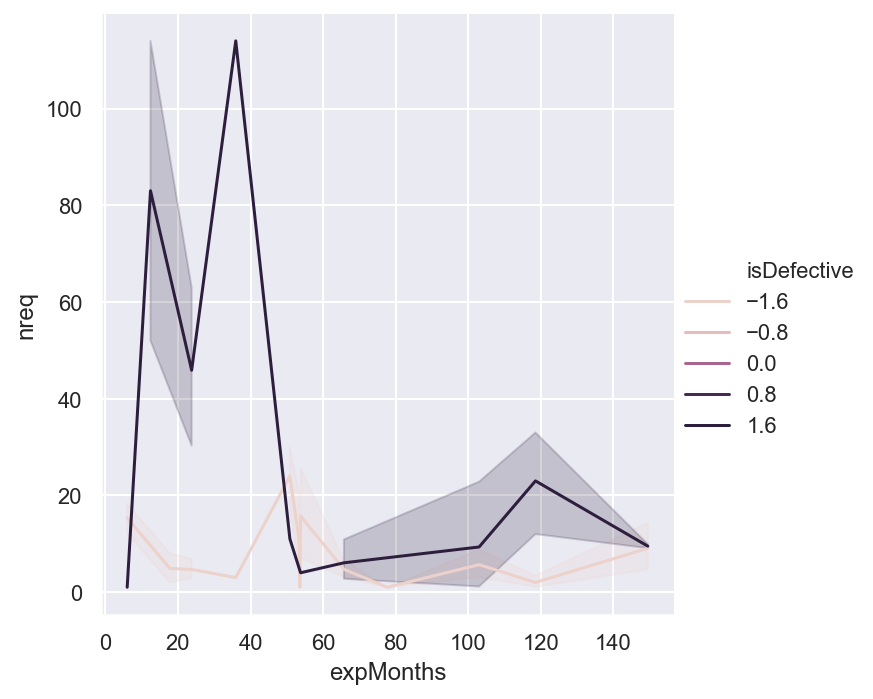

In [36]:
sns.relplot(x='expMonths', y='nreq', kind='line', data=train_3, hue='isDefective')

In [37]:
train_3['isDefective'] = train_3['isDefective'].replace({-1:'N', 1:'Y'})
train_3['isDefective'].value_counts()

N    253
Y     91
Name: isDefective, dtype: int64

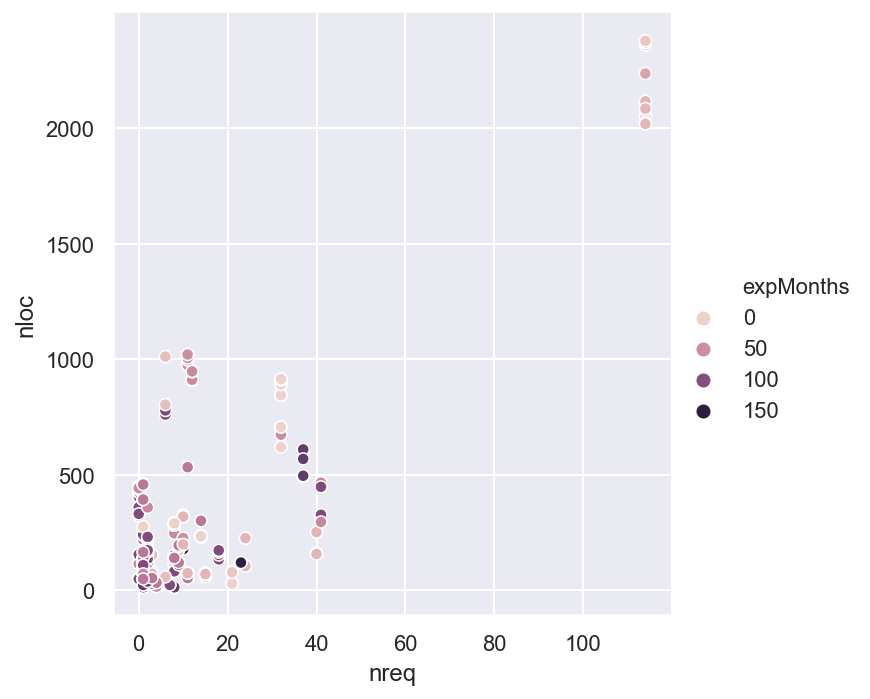

In [106]:
# hue: 색상 입히기 (범주형 hue='isDefective', 연속형 hue='expMonths')

sns.relplot(x='nreq', y='nloc', data=train_3, hue='expMonths')

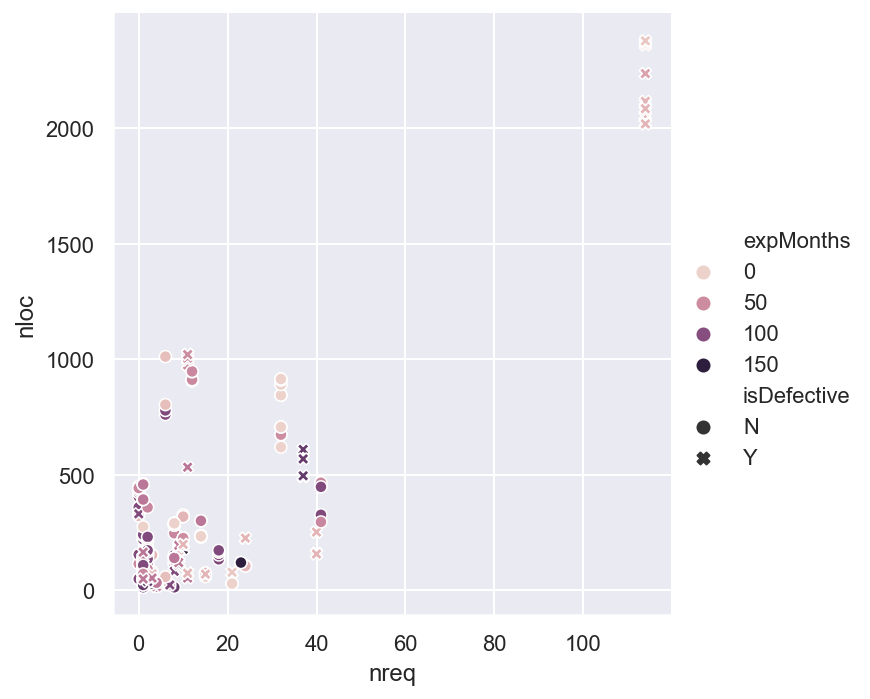

In [107]:
# marker style & hue

sns.relplot(x='nreq', y='nloc', data=train_3, style='isDefective', hue='expMonths')

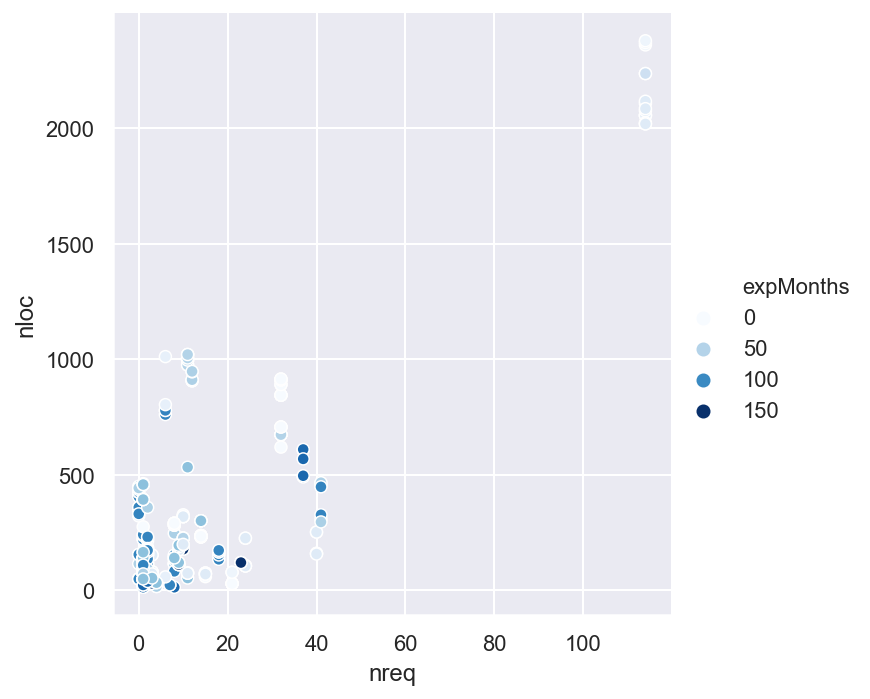

In [108]:
# marker 색상 선택 (search sentence : sns color palette)

sns.relplot(x='nreq', y='nloc', data=train_3, hue='expMonths', palette='Blues')

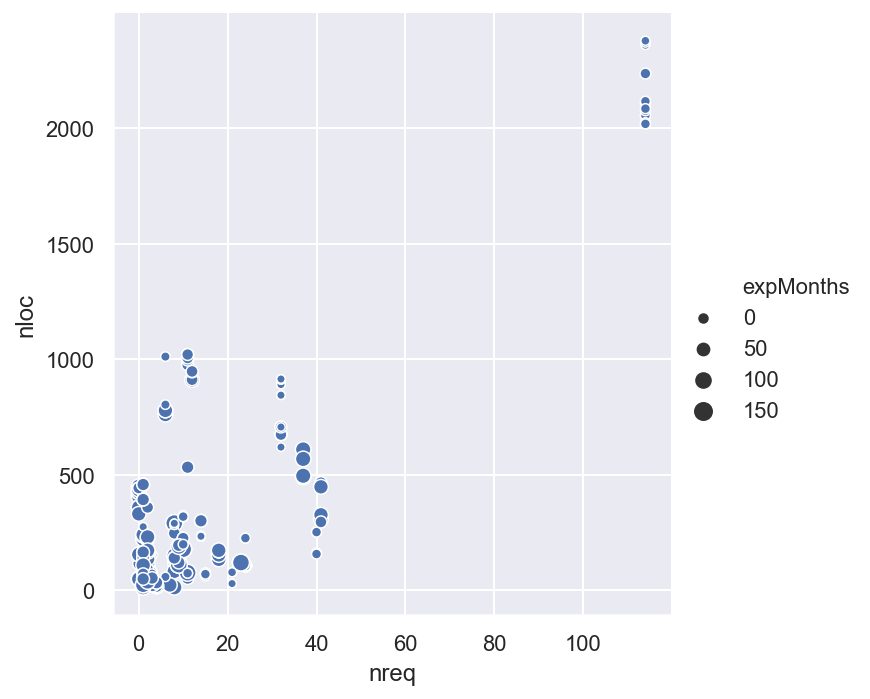

In [109]:
# marker size (search sentence : sns color palette)

sns.relplot(x='nreq', y='nloc', data=train_3, size='expMonths')

In [110]:
train_3['isDefective'] = train_3['isDefective'].replace({'N':-1, 'Y':1})

In [38]:
# 데이터 시각화를 위해 문자열 컬럼 제거 데이터 프레임 (train_4)

train_4 = train_3.drop(columns=['moduleName', 'changer'])

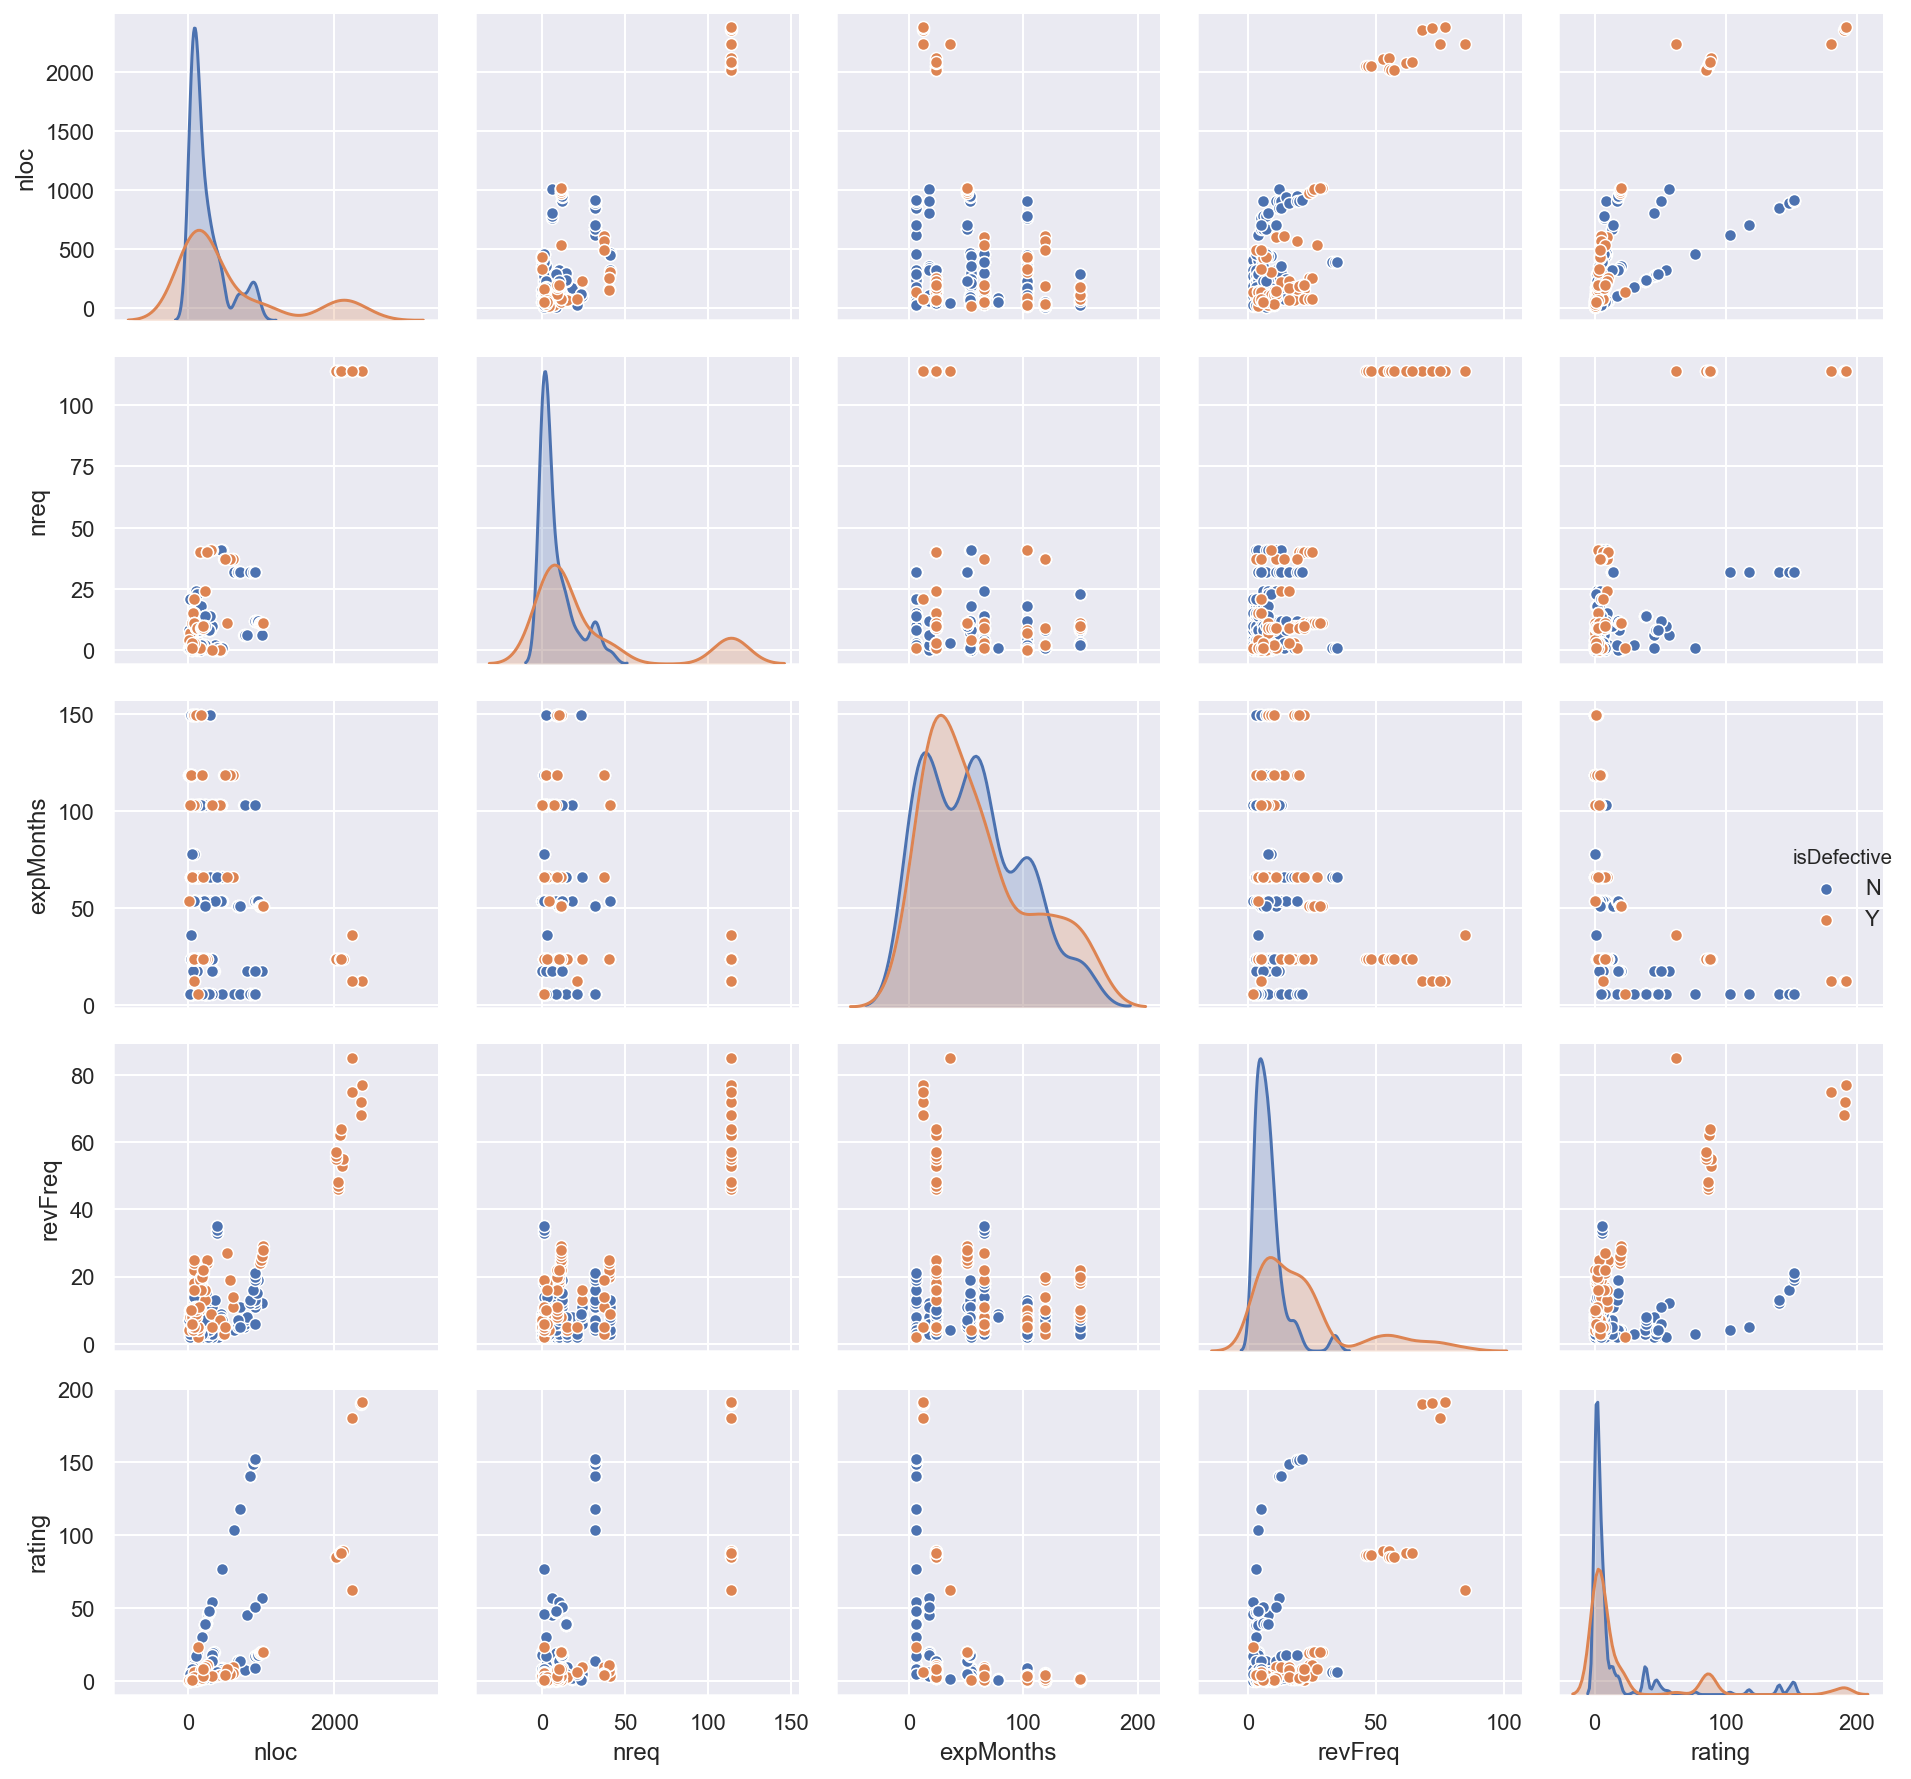

In [39]:
cols_1 = ['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv', 'effortToImpl', 'timeToImpl',\
          'nloc', 'maxParaCnt', 'funCnt', 'maxCyclo', 'isDefective']
cols_2 = ['nloc', 'upTrace', 'downTrace', 'pPORT', 'rPORT', 'revFreq', 'expLvOfDev', 'isDefective']
cols_3 = ['nloc', 'nreq', 'expMonths', 'revFreq', 'rating', 'isDefective']
sns.pairplot(train_4[cols_3], kind="scatter", height=2.5, hue="isDefective")
plt.tight_layout()
plt.show()

In [213]:
# 결함 상태 (-1: 미결함 / 1: 결함)에 따른 각 컬럼들의 평균 값

train_4.groupby(["isDefective"])[train_4.columns].mean()

,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,maxParaCnt,...,avgCyclo,pPORT,rPORT,revFreq,expMonths,nreq,nsud,ntest,isDefective,rating
isDefective,,,,,,,,,,,,,,,,,,,,,
-1.0,728.976285,88.173913,5350.141270,24.308045,11.235482,257532.688104,14307.371561,244.766798,1.000000,2.193676,...,5.491918,41.861660,12.660079,7.901186,56.392276,8.426877,1.644269,1.296443,-1.0,15.663484
1.0,1592.692308,171.054945,12799.120013,32.733223,9.603156,624552.569186,34697.364955,579.934066,0.857143,2.296703,...,5.874988,57.846154,28.120879,21.813187,60.146640,29.065934,1.516484,17.802198,1.0,23.282521


In [358]:
corrMatt = train_4
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

              progLength   vocaCnt    volume  difficultyLv    progLv  \
progLength      1.000000  0.949484  0.997717      0.799243 -0.020028   
vocaCnt         0.949484  1.000000  0.946523      0.775047 -0.070809   
volume          0.997717  0.946523  1.000000      0.763237  0.001956   
difficultyLv    0.799243  0.775047  0.763237      1.000000 -0.326518   
progLv         -0.020028 -0.070809  0.001956     -0.326518  1.000000   
effortToImpl    0.967702  0.883536  0.974970      0.743696 -0.009119   
timeToImpl      0.967702  0.883536  0.974970      0.743696 -0.009119   
nloc            0.491259  0.410703  0.489107      0.282797  0.358616   
minParaCnt      0.001813 -0.142635  0.002724     -0.023149  0.024360   
maxParaCnt      0.511750  0.513057  0.488133      0.620269 -0.111627   
totalParaCnt    0.736467  0.668881  0.739983      0.551563  0.321257   
funCnt          0.796966  0.793035  0.800071      0.660101 -0.088475   
minCyclo       -0.107111 -0.129154 -0.111792     -0.043683 -0.10

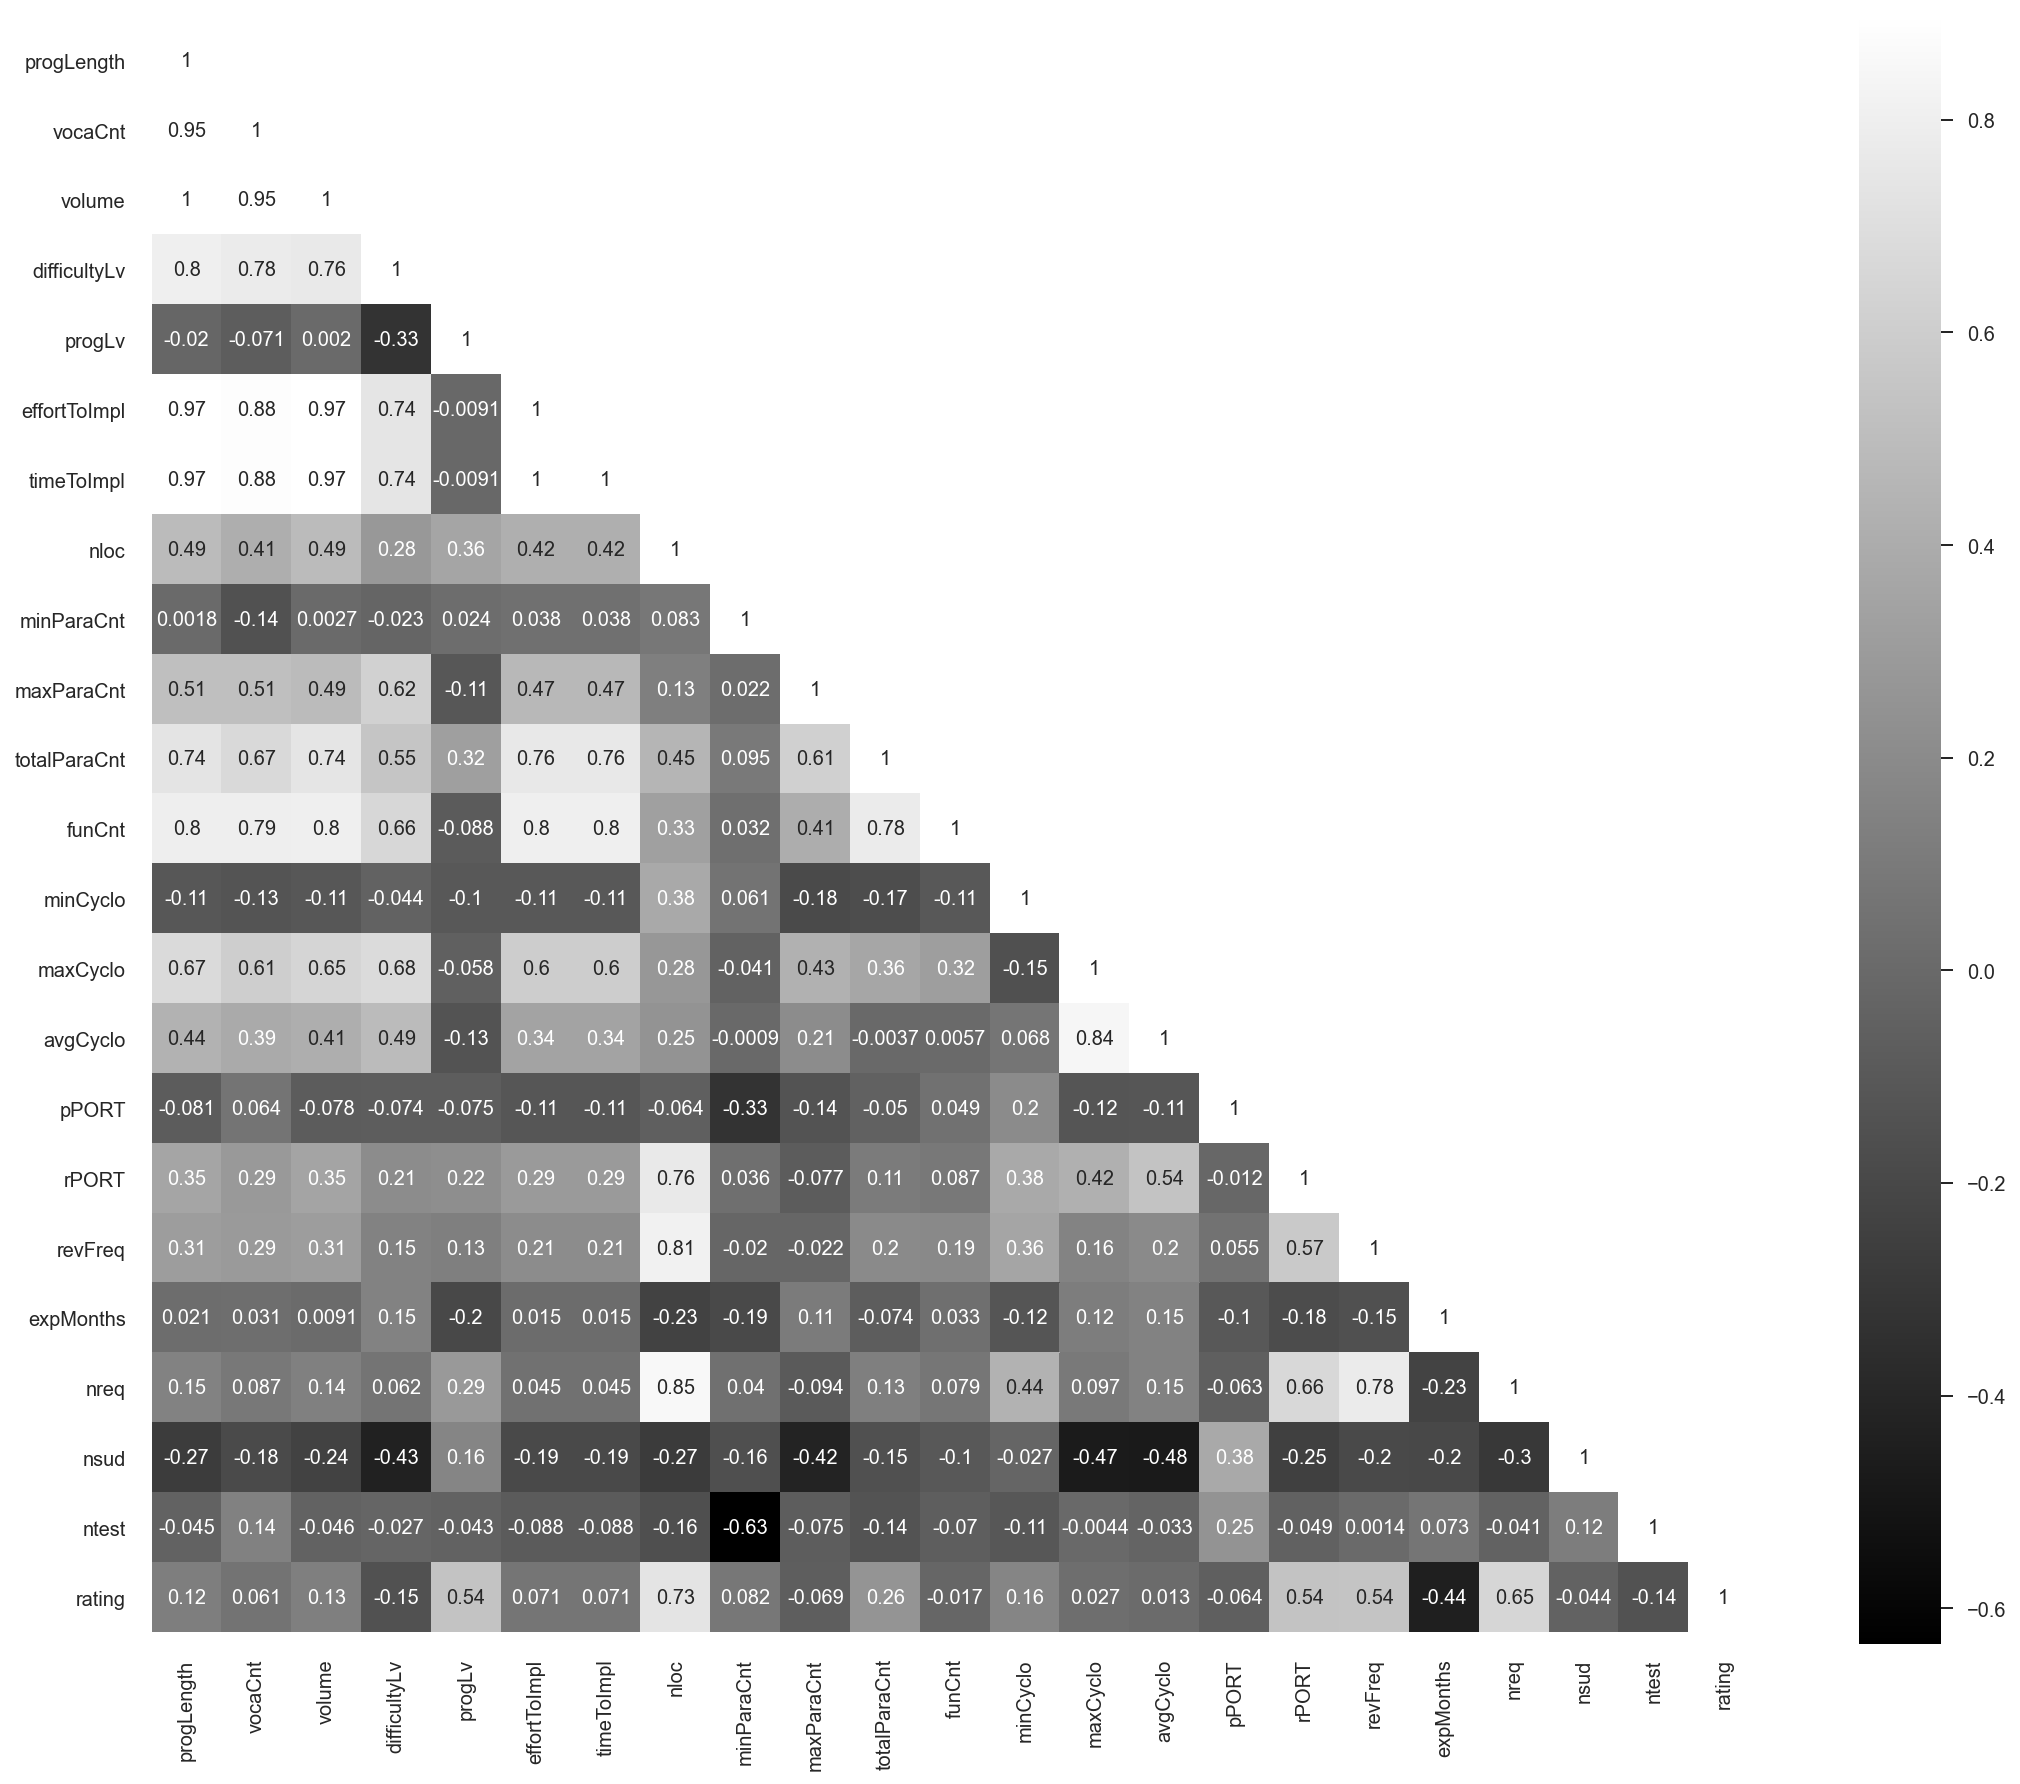

In [367]:
#top_corr_features = corrmat.index[abs(corrmat["isDefective"])>=0]
# plot
plt.figure(figsize=(18,15))
#g = sns.heatmap(corrMatt, mask=mask, annot=True, vmax=.9, square= 10, cmap="RdYlGn")
g = sns.heatmap(corrMatt, mask=mask, annot=True, vmax=.9, square= 10, cmap="gray")
plt.show()

In [286]:
# feature importance

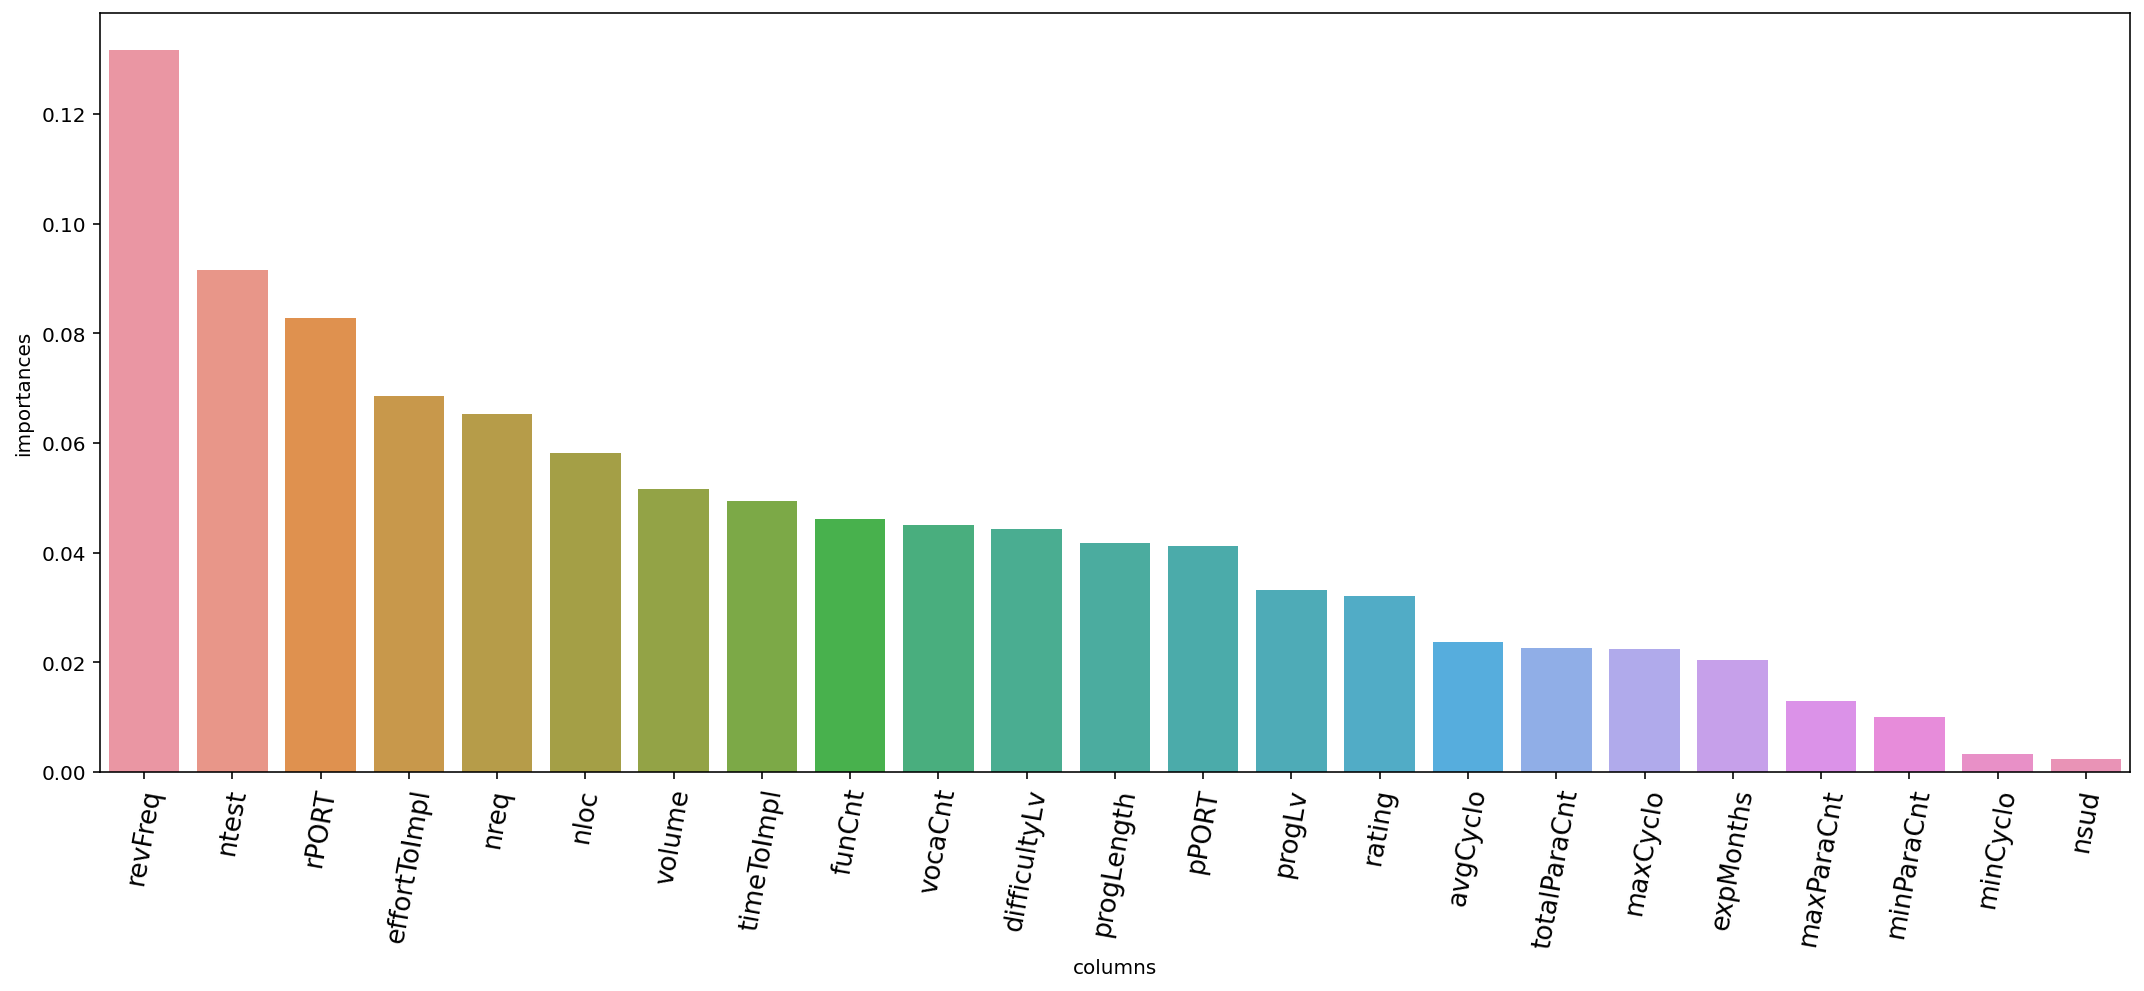

In [216]:
from sklearn.ensemble import RandomForestClassifier

X = train_4.drop(['isDefective'], axis=1)
Y = train_4['isDefective']

# RandomForest
clf = RandomForestClassifier(random_state=42, max_depth=6)
clf.fit(X, Y)
feature_importance = clf.feature_importances_

# plot
df_fi = pd.DataFrame({'columns':X.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > 0] # importance가 0이상인 것만 
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()

#### 데이터 전처리 2 
- 범주형 -> 숫자형

In [11]:
# 3. 전처리 2 : 범주형 데이터(sex, embarked)-> 숫자형 데이터
# onehot encoding 을 사용

# onehot encoding
onehot_boundary = pd.get_dummies(df_2["affectedBoundary"])
onehot_boundary

,EE System,Product,Software,Vehicle,na
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
552,0,1,0,0,0
553,0,1,0,0,0
554,0,1,0,0,0
555,1,0,0,0,0


In [23]:
df_2["affectedBoundary"].value_counts()

EE System    194
Product      167
Vehicle      153
Software      23
na            20
Name: affectedBoundary, dtype: int64

In [29]:
df_2.groupby(["affectedBoundary"])["isDefective"].mean()

affectedBoundary
EE System    0.134021
Product      0.173653
Software     0.000000
Vehicle      0.202614
na           0.000000
Name: isDefective, dtype: float64

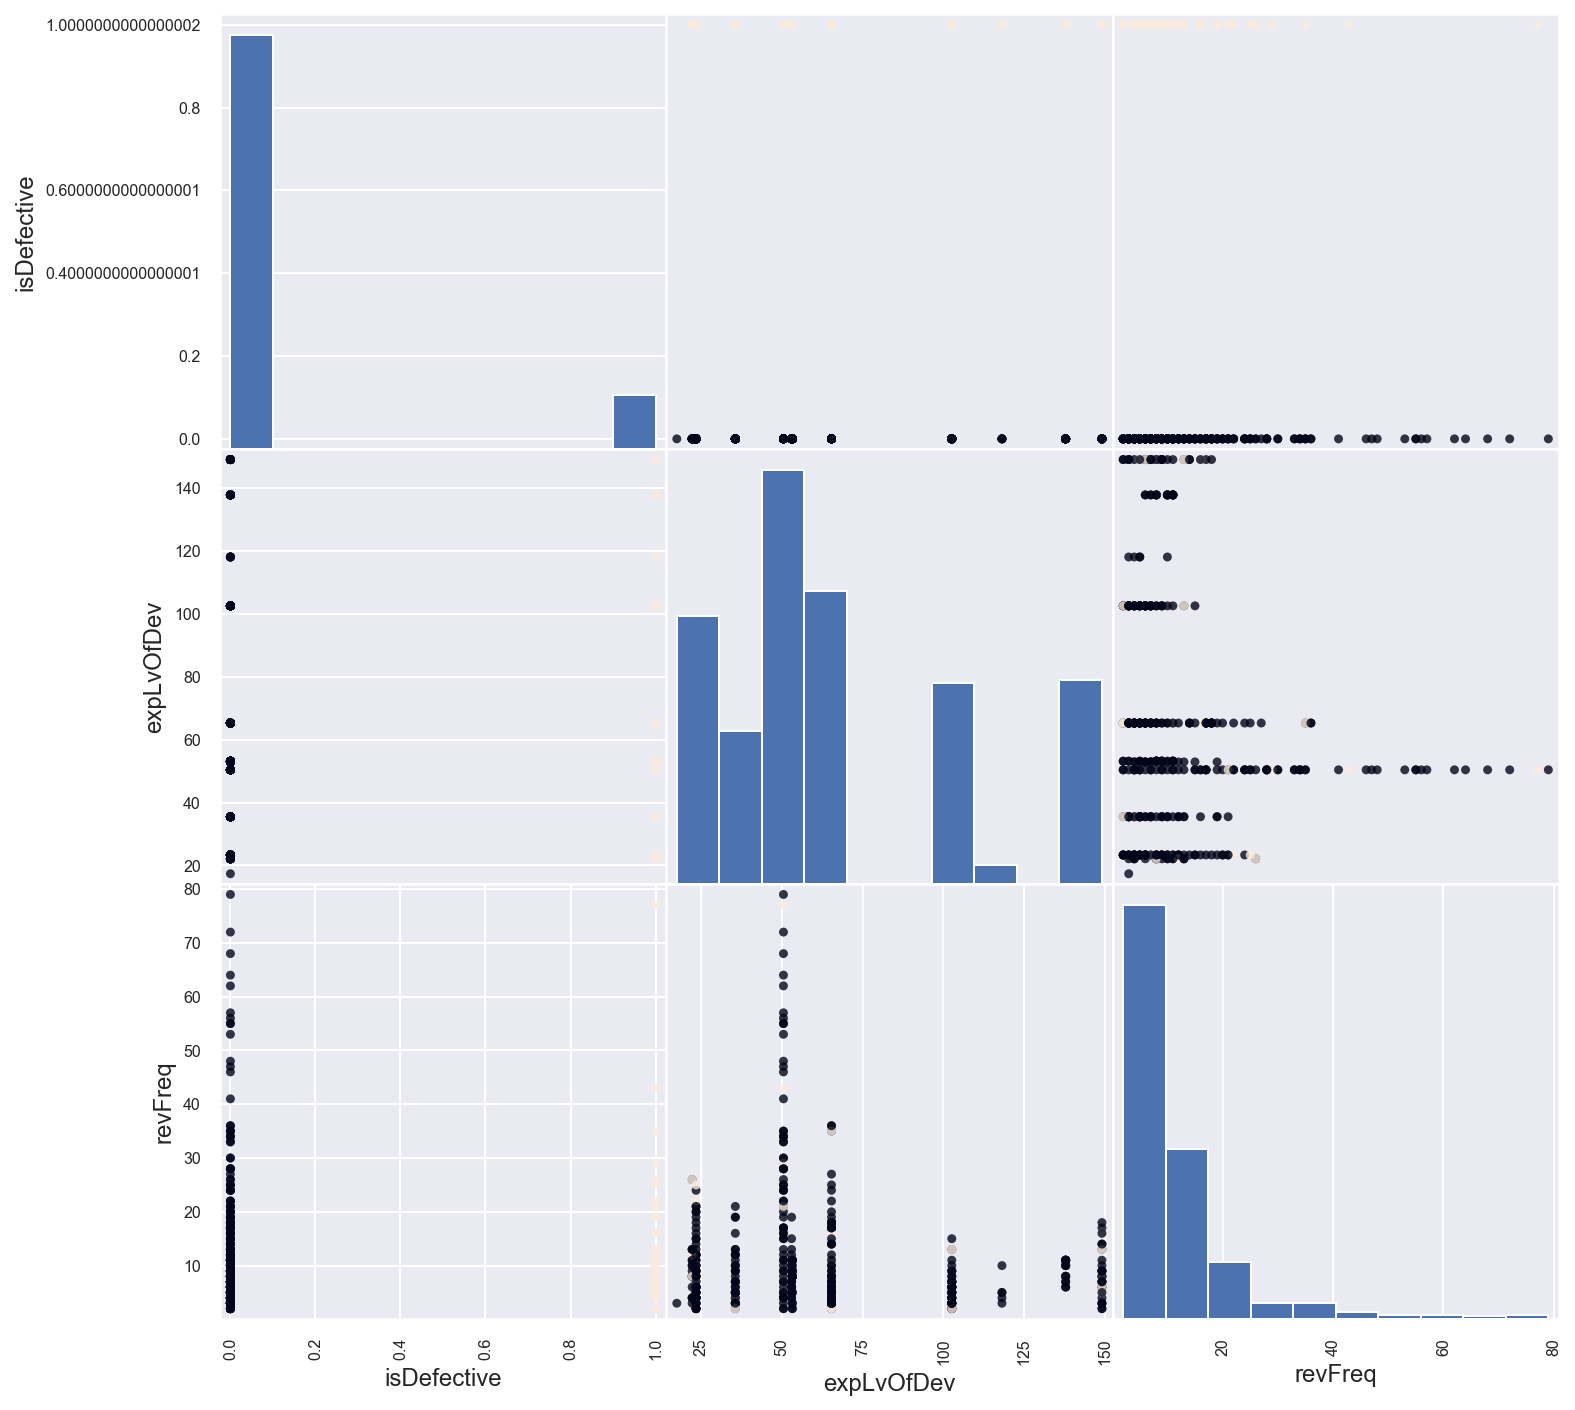

In [94]:
df_target = df_4["isDefective"]
df_cluster = df_4[["isDefective", "expLvOfDev", "revFreq"]]
pd.plotting.scatter_matrix(df_cluster, c=df_target, s=80, alpha=0.8, 
                           figsize=[12,12])
print('')

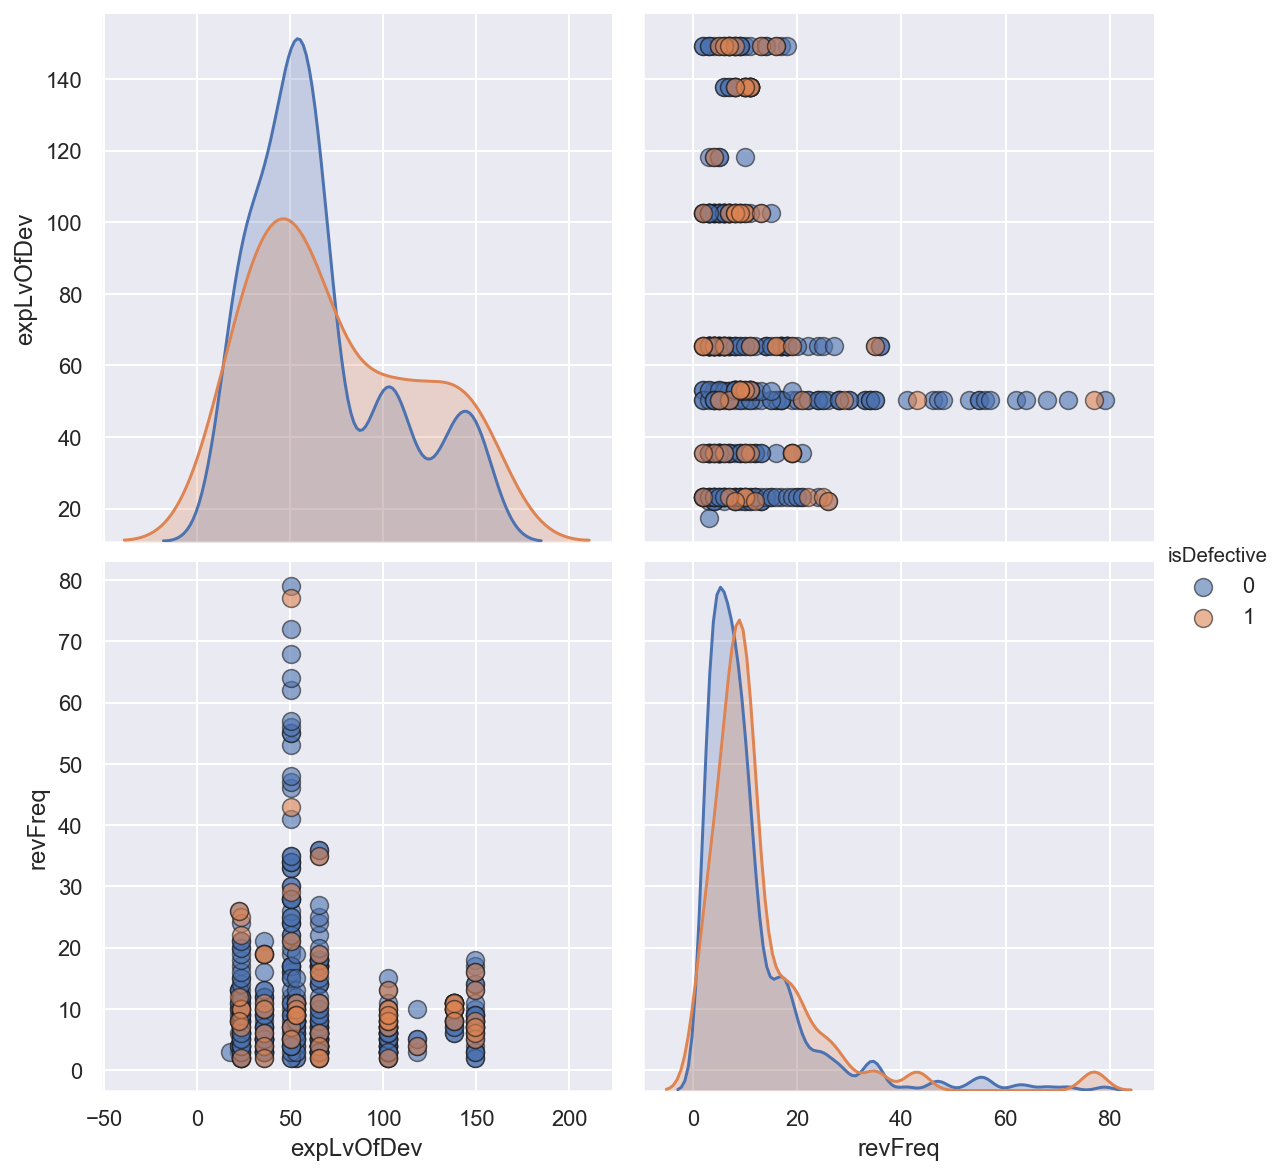

In [95]:
try:
    sns.pairplot(df_cluster, hue="isDefective", plot_kws ={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, size=4)
except Exception as e:
    print(e)
    pass

In [115]:
train_all = train_4.copy()

In [116]:
# outliers 데이터 제거

# trainWithoutOutliers = train_all[np.abs(train['Appliances'] - train_all['Appliances'].mean()) <= (1*train_all['Appliances'].std())]
# print(train_all.shape)
# print(trainWithoutOutliers.shape)

In [117]:
train_all.columns

Index(['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv',
       'effortToImpl', 'timeToImpl', 'nloc', 'minParaCnt', 'maxParaCnt',
       'totalParaCnt', 'funCnt', 'minCyclo', 'maxCyclo', 'avgCyclo', 'pPORT',
       'rPORT', 'revFreq', 'expMonths', 'nreq', 'nsud', 'ntest', 'isDefective',
       'rating'],
      dtype='object')

In [118]:
# all 데이터
X = train_all.drop(["isDefective"], axis=1)
Y = train_all["isDefective"]

In [119]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [120]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [121]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(240, 23) (240,) (104, 23) (104,)


### Scaling

In [228]:
# scaler = MinMaxScaler() # 스케일러 인스턴스화
# x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train),
#                       columns=x_train.columns)
# x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test),
#                       columns=x_test.columns)

### Model Test

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

In [123]:
model = DecisionTreeClassifier(max_depth=20, criterion='entropy', random_state=0).fit(x_train, y_train)
#GNB_mdl = GaussianNB().fit(train_X, train_y)

In [124]:
y_pred = model.predict(x_test)

In [335]:
# Decision Tree Classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.92      0.96      0.94        75
         1.0       0.88      0.79      0.84        29

    accuracy                           0.91       104
   macro avg       0.90      0.88      0.89       104
weighted avg       0.91      0.91      0.91       104



[Text(0.5, 1.0, 'prediction')]

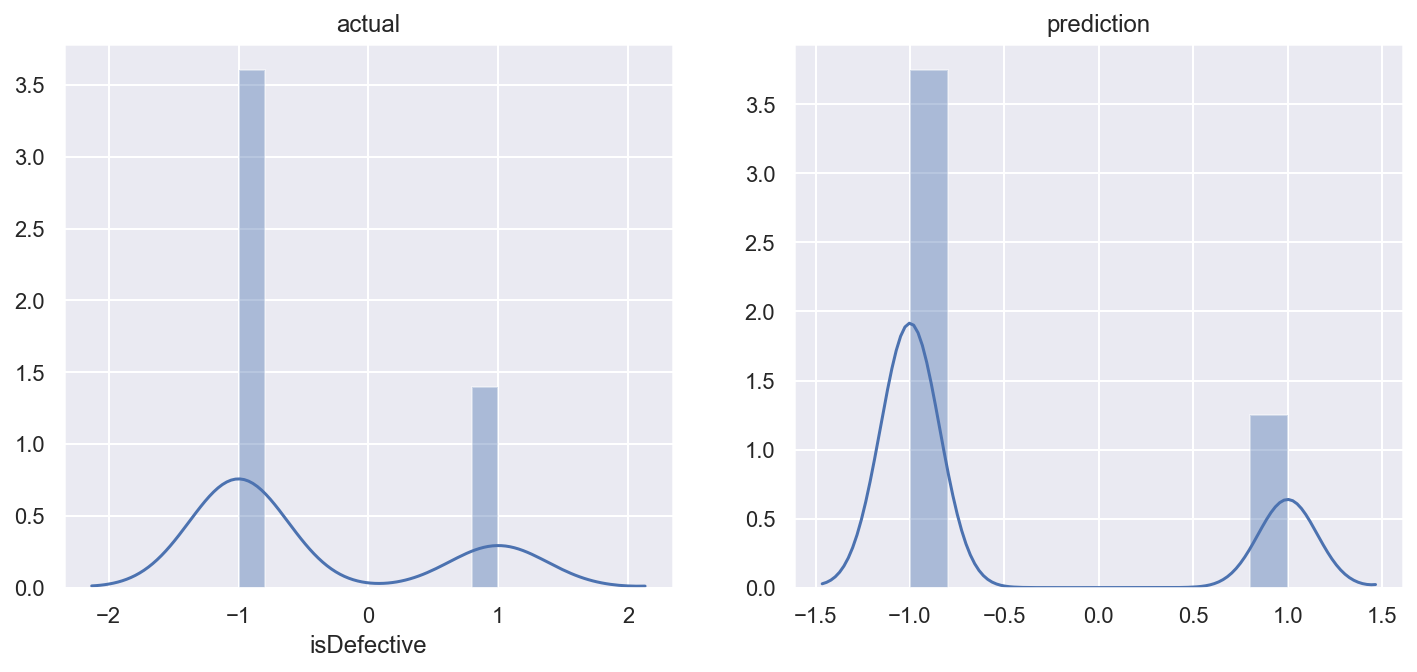

In [313]:
# 학습 데이터 예측 결과 시각화

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=10)
ax1.set(title="actual")
sns.distplot(y_pred, ax=ax2, bins=10)
ax2.set(title='prediction')

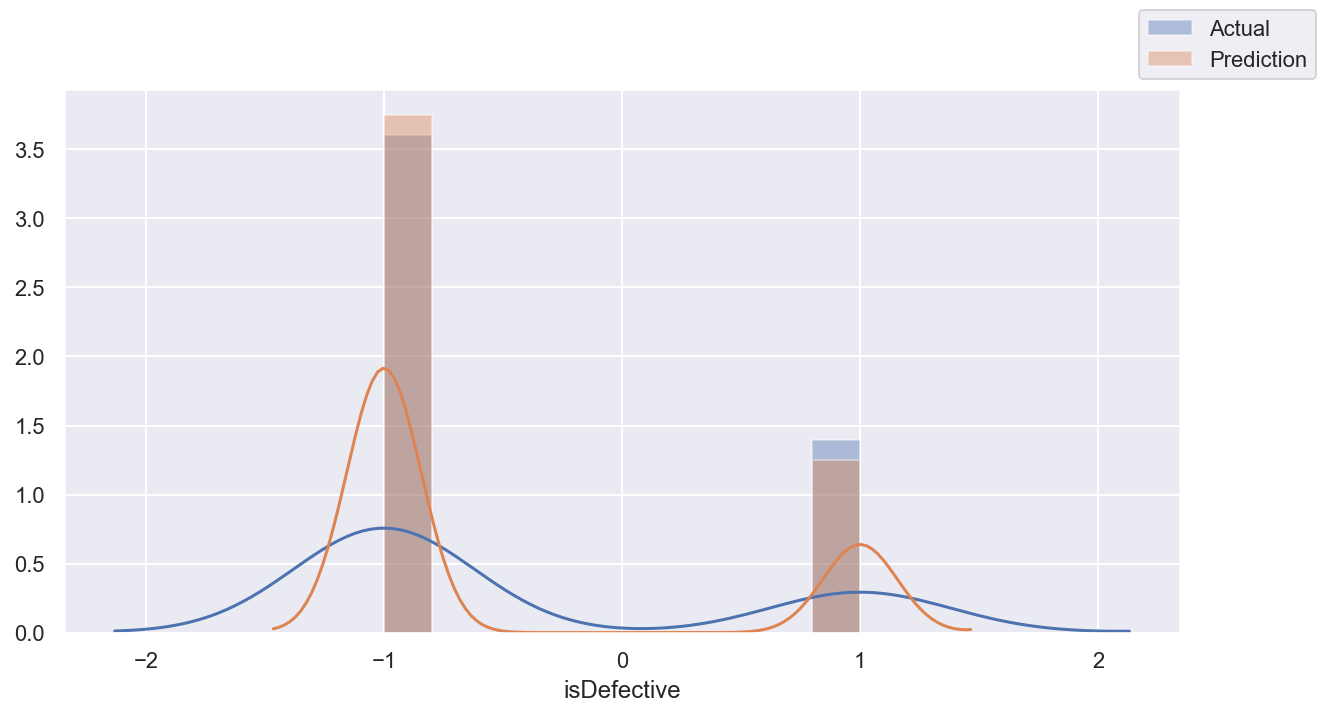

In [330]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(10, 5)
sns.distplot(y_test, ax=ax, bins=10)
sns.distplot(y_pred, ax=ax, bins=10)
fig.legend(labels=['Actual','Prediction'])


In [151]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.metrics import *
from sklearn.model_selection import ParameterGrid

model_parameter_dict = dict() # key : 모델, value : 파라미터 그리드
model_parameter_dict[LR] = ParameterGrid({})
model_parameter_dict[KNN] = ParameterGrid({"n_neighbors":[1, 3, 5, 7],
                                           "weights":["uniform", "distance"],
                                           "leaf_size":[30, 50, 70]})
model_parameter_dict[DTC] = ParameterGrid({"max_depth":[3, 5, 8, 10, 15, 20],
                                            "min_samples_leaf":[1, 3, 5]})
model_parameter_dict[SVC] = ParameterGrid({'kernel':['rbf'],
                                            "C":[2**-4, 2**-2, 2**0, 2** 2],
                                            "gamma":[1, 10 ,100]})
model_parameter_dict[GNB] = ParameterGrid({})
model_parameter_dict[RFC] = ParameterGrid({"n_estimators":[25, 50, 75, 100, 150],
                                           "max_depth":[1, 3, 5],
                                           "min_samples_split":[2, 4]})
# model_parameter_dict[SGDC] = ParameterGrid({"max_iter":[10000, 100000, 1000000],
#                                             "tol":[1e-3, 1e-5, 1e-7]})

In [152]:
best_score = 0

for model in model_parameter_dict.keys():
    for parameter in model_parameter_dict[model]:
        M = model(**parameter).fit(x_train, y_train)
        y_pred = M.predict(x_test)
        score = f1_score(y_test, y_pred)

        print("current score: ", score)
        print("best score: ", best_score)

        if score > best_score:
            best_score = score
            best_model = model
            best_parameter = parameter

current score:  0.34146341463414637
best score:  0
current score:  0.8076923076923076
best score:  0.34146341463414637
current score:  0.8076923076923076
best score:  0.8076923076923076
current score:  0.64
best score:  0.8076923076923076
current score:  0.823529411764706
best score:  0.8076923076923076
current score:  0.7083333333333333
best score:  0.823529411764706
current score:  0.75
best score:  0.823529411764706
current score:  0.6956521739130435
best score:  0.823529411764706
current score:  0.75
best score:  0.823529411764706
current score:  0.8076923076923076
best score:  0.823529411764706
current score:  0.8076923076923076
best score:  0.823529411764706
current score:  0.64
best score:  0.823529411764706
current score:  0.823529411764706
best score:  0.823529411764706
current score:  0.7083333333333333
best score:  0.823529411764706
current score:  0.75
best score:  0.823529411764706
current score:  0.6956521739130435
best score:  0.823529411764706
current score:  0.75
best 

In [153]:
best_model

sklearn.tree._classes.DecisionTreeClassifier

In [154]:
best_parameter

{'max_depth': 8, 'min_samples_leaf': 1}

In [155]:
best_score

0.9056603773584906

In [156]:
model = DTC(**best_parameter).fit(x_train, y_train)

In [158]:
y_pred = model.predict(x_test)

In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        75
           1       1.00      0.86      0.93        29

    accuracy                           0.96       104
   macro avg       0.97      0.93      0.95       104
weighted avg       0.96      0.96      0.96       104



### Evaluation

### Save Best Model

# Predict new data

## New data information
- Project
- Repository
- 